#  Concours sur la Smart City: aidez Paris à devenir une smart-city !
## Résultats contribueront à une optimisation des tournées pour l’entretien des arbres de la ville.

<img src="img/oc.png" width="300" height="300"/>
<img src="img/paris_data.png" width="300" height="300"/>

# Objectives:
- Comprendre le mieux possible les donnée: décrir brièvement (nombre de lignes, nombre de colonnes et nombre de valeurs manquantes)
- Réaliser une analyse exploratoire avec un jeu de données portant sur les arbres de la ville de Paris
    - Calculer les indicateurs statistiques basiques (moyenne et écart-type) pour different colonnes
    - Comparer les ordres de grandeur des grandeurs statistiques pour differents collonnes
- Effectuer une analyse statistique univariée
    - Calculer les moyennes, médianes et quantiles des distributions
    - Tracer au moins un représentation graphique d’une distribution statistique
    - Identifiér les éventuelles valeurs aberrantes (avec une définition des valeurs aberrantes basée sur un multiple des quantiles de la distribution).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plot_arbres(df_arbres):
    m = folium.Map(location=["48.856614", "2.3522219"], zoom_start=11)
    callback = ('function (row) {' 
                'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"});'
                'var genre = row[2];'
                'var espece = row[3];'
                'var libelle_francais = row[4];'
                'var circonference = row[5];'
                'var hauteur =  row[6];'
                'var stade_developpement = row[7];'
                'var remarquable = row[8];'
                "var popup = L.popup({maxWidth: '300'});"
                "const display_text = {text: '<table><tbody><tr><td><b>Genre</b></td><td>'+genre+'</td></tr><tr><td><b>Espèce</b></td><td>'+espece+'</td></tr><tr><td><b>Libellé</b></td><td>'+libelle_francais+'</td></tr><tr><td><b>Circonférence (cm)</b></td><td>'+circonference+'</td></tr><tr><td><b>Hauteur (m)</b></td><td>'+hauteur+'</td></tr><tr><td><b>Stade</b></td><td>'+stade_developpement+'</td></tr><tr><td><b>Remarquable</b></td><td>'+remarquable+'</td></tr></tbody></table>'};"
                "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
                "popup.setContent(mytext);"
                "marker.bindPopup(popup);"
                'return marker};')
    m.add_child(FastMarkerCluster(df_arbres[["geo_point_2d_a", 
                                  "geo_point_2d_b", 
                                  "genre", 
                                  "espece", 
                                  "libelle_francais", 
                                  "circonference_cm", 
                                  "hauteur_m", 
                                  "stade_developpement", 
                                  "remarquable"]].values.tolist(), 
                              showCoverageOnHover = True,
                              spiderfyOnMaxZoom = False,
                              disableClusteringAtZoom = 18,
                             callback = callback))
    return m

In [3]:
# afficher tout le dataset
def plot_data(df):
    '''
    Visualize the hole dataset in order to see the missing values
    Input:
        - df: DataFrame to plot
    '''
    plt.figure(figsize=(15, 10))
    splot = sns.heatmap(df.isna(), cbar = False)
    plt.title('Entire dataset',fontsize=25)
    plt.xlabel('Variables',fontsize=15)
    plt.ylabel('Observations',fontsize=15)

In [4]:
def plot_correlation(df):
    corr = df.corr()
    # Fill redundant values: diagonal and upper half with NaNs 
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    return (corr
     .style
     .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
     .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
    )

In [5]:
def get_values_of_interest(df, col):
    '''
    Used to eliminate outliers
    Input:
        - df: DataFrame
        - col: the column to analyse
    
    computes 
        min, max, med = Q2, 
        Q1-first quartile, Q3 - third quartile
        IQ = Q3 - Q1
    returns Q1-1/5*IQ<(o1, o2)<Q1+1/5*IQ
    '''
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQ = Q3 - Q1
    o1 = max(0,Q1-1.5*IQ)
    o2 = Q3+1.5*IQ
    return (o1,o2)

In [6]:
def get_libellefr_genreespece(df):
    '''
    Input: dataframe:df containing columns `libelle_francais`, `genre` et `espece`
    Output: dictionnaire with key: genre+espece and value: libellefr
    '''
    dict_result={}
    
    for genre in df[(~df.genre.isna()) & (~df.libelle_francais.isna())].genre.unique():
        for espece in df[(df.genre == genre) & (~df.libelle_francais.isna())].espece.unique():
            key = genre + '-' + espece

            value = list(df[(df.genre == genre) & (df.espece == espece) & (~df.libelle_francais.isna())].libelle_francais)
            dict_result[key] = value[0]
    
    return dict_result

# 1. Comprendre le mieux possible les donnée
- **Description des variables**: 
The variable description are also available on: [Arbre-Paris Data](https://opendata.paris.fr/explore/dataset/les-arbres/information/?disjunctive.typeemplacement&disjunctive.arrondissement&disjunctive.libellefrancais&disjunctive.genre&disjunctive.espece&disjunctive.varieteoucultivar&disjunctive.stadedeveloppement&disjunctive.remarquable)
    
    - Identification de donnée (ne va pa servir à grande chose pour notre analyse - à verifié juste les doublons)
        -  `id` : id de l'arbre
        - `id_emplacement` : identifiant de l'emplacement
    - Description de l'arbre
        - `domanialite` : type de lieu auquel appartient l'arbre
        - `type_emplacement` :  le type d'emplacement
        - `libelle_francais` : nom commun (vernaculaire) de l'espèce de l'arbre
        - `genre` : genre de l'arbre
        - `espece` : espèce de l'arbre
        - `variete` : variété de l'arbre
        - `circonference_cm` : circonférence en centimètres de l'arbre
        - `hauteur_m` : taille en mètres de l'arbre
        - `stade_developpement` : stade de développement de l'arbre
        - `remarquable` : si l'arbre est "remarquable" ou non (0, 1 ou NaN)
    - Emplacement de l'arbre
        - `arrondissement` : arrondissement de Paris où est situé l'arbre
        - `complement_addresse` : complement d'adress
        - `numero` : numéro de l'adress
        - `lieu` : adresse de l'arbre 
        - `geo_point_2d_a` : latitude de la position de l'arbre
        - `geo_point_2d_b` : longitude de la position de l'arbre


## Importation des données

In [7]:
data = pd.read_csv('data/p2-arbres-fr.csv', sep = ';', encoding='utf-8', decimal='.')
df = data.copy()
df.head(5)

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


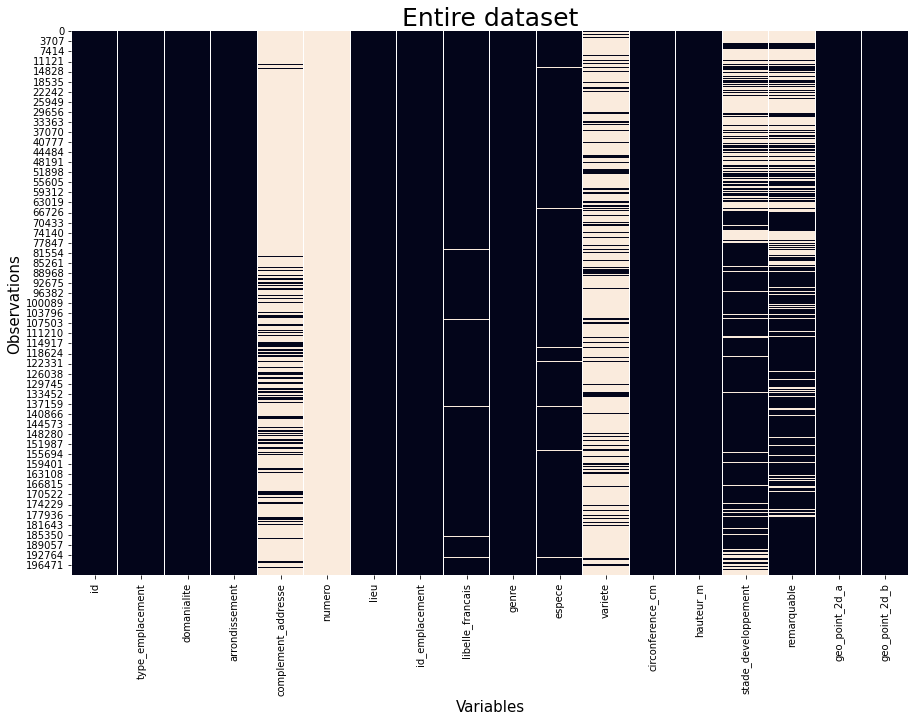

In [8]:
plot_data(df)

In [9]:
# quantité des données
print('Les quantité des données')
df.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df.dtypes

print('Conté les type des variables')
df.dtypes.value_counts()

Les quantité des données


(200137, 18)

Les type observé pour chaque variable


id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object

Conté les type des variables


object     11
float64     4
int64       3
dtype: int64

- **Lignes et colonnes**: 200137, 18
- **Types des variables**: qualitative: 13 quantitative: 5
    - quantitatives
        - discrètes :  ```id, circonference_cm, hauteur_m ```
        - continues :  ```geo_point_2d_a, geo_point_2d_b ```
    - qualitatives
        - nominales :  ```type_emplacement, domanialite, arrondissement, complement_addresse, numero, lieu, id_emplacement, libelle_francais, genre, espece, variete ```
        - ordinales :  ```stade_developpement, remarquable ```

# 2. Prémiere analyse de donnée

In [10]:
df.describe()

,id,numero,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,2.001370e+05,0.0,200137.000000,200137.000000,137039.000000,200137.000000,200137.000000
mean,3.872027e+05,NaN,83.380479,13.110509,0.001343,48.854491,2.348208
std,5.456032e+05,NaN,673.190213,1971.217387,0.036618,0.030234,0.051220
min,9.987400e+04,NaN,0.000000,0.000000,0.000000,48.742290,2.210241
25%,1.559270e+05,NaN,30.000000,5.000000,0.000000,48.835021,2.307530
50%,2.210780e+05,NaN,70.000000,8.000000,0.000000,48.854162,2.351095
75%,2.741020e+05,NaN,115.000000,12.000000,0.000000,48.876447,2.386838
max,2.024745e+06,NaN,250255.000000,881818.000000,1.000000,48.911485,2.469759


In [11]:
df.describe(include=[object])  

,type_emplacement,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,stade_developpement
count,200137,200136,200137,30902,200137,200137,198640,200121,198385,36777,132932
unique,1,9,25,3795,6921,69040,192,175,539,436,4
top,Arbre,Alignement,PARIS 15E ARRDT,SN°,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,101001,Platane,Platanus,x hispanica,Baumannii',A
freq,200137,104949,17151,557,2995,1324,42508,42591,36409,4538,64438


In [12]:
plot_correlation(df)

,id,numero,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
id,nan,nan,nan,nan,nan,nan,nan
numero,nan,nan,nan,nan,nan,nan,nan
circonference_cm,-0.010415,nan,nan,nan,nan,nan,nan
hauteur_m,0.006592,nan,0.000413,nan,nan,nan,nan
remarquable,0.009282,nan,0.009480,0.000070,nan,nan,nan
geo_point_2d_a,-0.100818,nan,0.008704,-0.002167,0.003465,nan,nan
geo_point_2d_b,0.300256,nan,-0.004617,0.004631,-0.011759,-0.010613,nan


In [13]:
# afficher les valeurs unique pour chaque variable
df.nunique()

id                     200137
type_emplacement            1
domanialite                 9
arrondissement             25
complement_addresse      3795
numero                      0
lieu                     6921
id_emplacement          69040
libelle_francais          192
genre                     175
espece                    539
variete                   436
circonference_cm          531
hauteur_m                 143
stade_developpement         4
remarquable                 2
geo_point_2d_a         200107
geo_point_2d_b         200114
dtype: int64

In [14]:
# verifié les valeurs manquants en affichant le pourcentage
print(df.isna().mean().sort_values(ascending=True))

id                     0.000000
hauteur_m              0.000000
circonference_cm       0.000000
geo_point_2d_a         0.000000
id_emplacement         0.000000
lieu                   0.000000
geo_point_2d_b         0.000000
arrondissement         0.000000
type_emplacement       0.000000
domanialite            0.000005
genre                  0.000080
libelle_francais       0.007480
espece                 0.008754
remarquable            0.315274
stade_developpement    0.335795
variete                0.816241
complement_addresse    0.845596
numero                 1.000000
dtype: float64


In [15]:
## verifié les valeurs dupliqué sur le même l'emplacement geo_point_2b_a, geo_point_2b_b
df.duplicated(['geo_point_2d_a','geo_point_2d_b']).sum()

11

### Suite à cette premiere analyse on observe que:
1) On a des variables: 
- avec des ***métadonnée*** qui n'importe pas d'utilité:
  - `id` et `id_emplacement`
- avec des ***valeurs unique ou vide*** qui n'importe pas d'utilité:
  - `type_emplacement` le seule valeur est 'Arbre'
  - `numero` le variable vide
- avec beaucoup des ***valeurs manquants***:
  - `libelle_francais` avec 192 valeurs uniques, `genre` avec 175 valeurs uniques, `espece` avec 539 valeurs uniques sont liée un avec l'autre et je pence que on peux deduire beaucoup des valeurs manquants.
  - `complement_addresse`, `variete` - beacoup des valeurs manquants, pas très exploitable, c'est pour quoi on elimine ces variables
  - `remarquable` et `stade_development` aussi quand meme beaucoup des valeurs manquant > 30% qui sera très difficile à exploirer, mais ce qui concerne la variable `remarquable` on pourra dire que tous les valeurs qui sont NaN on le met à 0 (non rémarquable). Et pour la variable `stade_development` on pourra peut être le deduire (predire) à partir de deux variable `circonference_cm` et `hauteur_m`. Aussi pour la comprehension de variable  `stade_dévelopement` je note ses valeurs. 
    - J :Jeune, 
    - JA:Jeune Adulte, 
    - A :Adulte, 
    - M :Mature,
  
2) On observe des doublons si on prends en compte les deux valeurs de positionnement geographique (latitude, longitude) `geo_point_2d_a`,`geo_point_2d_b`

3) On observe des valeurs aberantes
  - `circonference_cm` et `hauteur_m` ont des valeurs maximale aberantes, asusi les valeurs qui sont egaux à 0 peut etre faudra les mesurer du nouveau

4) Aussi on vois le variable `lieu` qui contient parfois un '/' pour diviser le lieu avec une addresse en complement. Peut être il faut spliter pour garder juste le lieux


# 3. Nettoyage des données

## 3.1 Elimination des valeurs aberrantes

Le critère [IQR](https://en.wikipedia.org/wiki/Interquartile_range#Outliers) peut être utilisé pour voir les valeurs aberantes pour les variables `circonference_cm` et `hauteur_m`. Mais surtout prendre en compte la vie réele et voir quelle est les valeurs maximales pour `circonference_cm` et `hauteur_m`. Je pence que ces variables n'est pas une distribution normale du coup on prendra les valeurs reele de la vie de Paris comme indicateurs.

[Arbre-avec le plus grande circonférence à Paris](https://www.pariszigzag.fr/secret/lieux-insolites/arbres-remarquables-paris):
Le platane d’Orient du Parc Monceau
Le plus gros arbre de Paris est à admirer dans l’ouest du parc Monceau, au cœur du 8ème arrondissement. Ce platane d’Orient est reconnaissable entre mille à son énorme tronc noueux qui mesure près de **8 mètres de circonférence**, ses branches bien étalées, ainsi que sa hauteur de 30 mètres. Il a été planté ici en 1814, ce qui fait de lui un bicentenaire, mais n’est pas pour autant le plus vieux de Paris, le doyen des platanes se trouvant lui au Jardin des Plantes.

[Arbre-avec le plus grande hauteur à Paris](https://agriculture.gouv.fr/le-plus-grand-arbre-de-paris-veille-sur-le-78-rue-de-varenne)
Le plus grand arbre de Paris, un platane d’Orient plus que centenaire, veille sur le parc de l’hôtel de Villeroy, siège du ministère de l’Agriculture et de l'Alimentation. Figure emblématique du jardin, il en est aussi le plus ancien pensionnaire. **30 mètres de haut !**

On peux aussi voir les arbre qui sont avec les valeurs suivants. 
 - circonference = 0cm et les hauteurs > 0m
 - circonference = 0cm et les hauteurs = 0m
 - circonference > 0cm et les hauteurs = 0m

En fait ces valeurs peuve etre correcte, mais il faut mieux faire une nouvelle mesure pour s'asurer, et pour l'instant on va supposé ces valeurs incorrecte et on vas effacer de notre clean data.

In [16]:
mask = (((df.circonference_cm == 0) & (df.hauteur_m == 0)) |
    ((df.circonference_cm == 0) & (df.hauteur_m > 0)) |
    ((df.circonference_cm > 0) & (df.hauteur_m == 0)))
#df[mask].arrondissement.value_counts()
#sns.barplot(x=df[mask].arrondissement.value_counts(), y=df[mask].arrondissement.value_counts().index, data=df[mask])
df = df[~mask]

In [17]:
print('Suite au critère IQR on a le minimum de {0}m et le maximum de {1}m pour l\'hauter'.format(get_values_of_interest(df, 'hauteur_m')[0], get_values_of_interest(df, 'hauteur_m')[1]))
print('Suite au critère IQR on a le minimum de {0}cm et le maximum de {1}cm pour la circonference'.format(get_values_of_interest(df, 'circonference_cm')[0], get_values_of_interest(df, 'circonference_cm')[1]))

Suite au critère IQR on a le minimum de 0m et le maximum de 26.0m pour l'hauter
Suite au critère IQR on a le minimum de 0cm et le maximum de 237.5cm pour la circonference


,id,numero,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,1.599130e+05,0.0,159913.000000,159913.000000,127393.00000,159913.000000,159913.000000
mean,3.802321e+05,NaN,92.387304,10.354418,0.00135,48.855831,2.346137
std,5.182810e+05,NaN,58.730250,5.115447,0.03672,0.025858,0.049322
min,9.987400e+04,NaN,1.000000,1.000000,0.00000,48.742290,2.210416
25%,1.873070e+05,NaN,50.000000,6.000000,0.00000,48.836809,2.307584
50%,2.331330e+05,NaN,80.000000,10.000000,0.00000,48.855188,2.348737
75%,2.770040e+05,NaN,125.000000,14.000000,0.00000,48.874126,2.383178
max,2.023468e+06,NaN,790.000000,30.000000,1.00000,48.911485,2.469759


<AxesSubplot:xlabel='hauteur_m'>

Text(0.5, 1.0, 'Boîte à moustaches\n pour hauteur')

Text(0.5, 0, 'Hauteur (m)')

<AxesSubplot:xlabel='circonference_cm'>

Text(0.5, 0, 'Circunference (cm)')

Text(0.5, 1.0, 'Boîte à moustaches\n pour circunference')

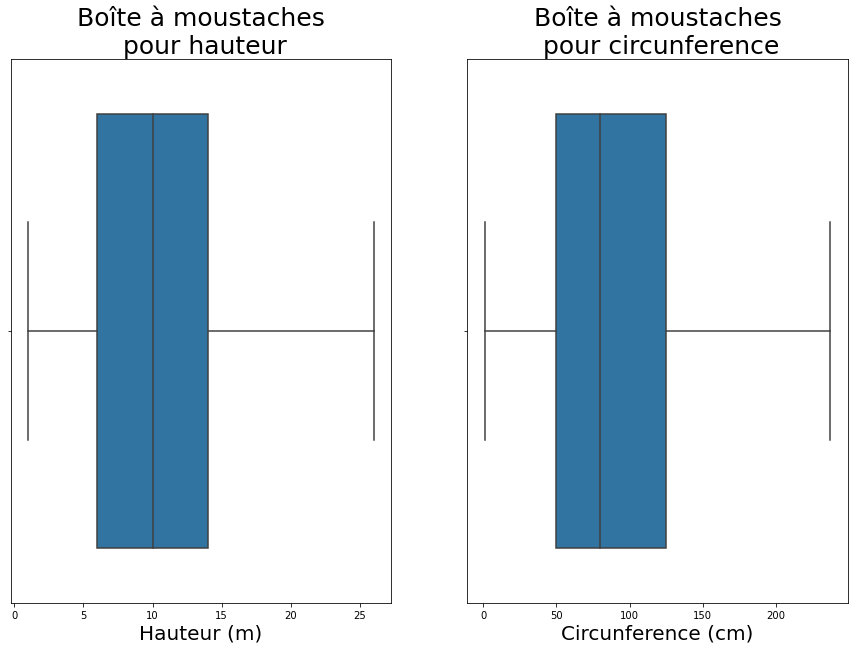

In [18]:
mask = ~((df.circonference_cm > 800) | (df.hauteur_m > 30))
df = df[mask]
df.describe()

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.boxplot(x=df["hauteur_m"], showfliers = False, ax = axes[0])
axes[0].set_title('Boîte à moustaches\n pour hauteur', fontsize=25);

axes[0].set_xlabel('Hauteur (m)', fontsize=20);

sns.boxplot(x=df["circonference_cm"], showfliers = False, ax = axes[1])
axes[1].set_xlabel('Circunference (cm)', fontsize=20);
axes[1].set_title('Boîte à moustaches\n pour circunference', fontsize=25);
plt.show()


#### Synthèse de l’analyse:
 - On observe les pluspart des arbre ont une hauteur de 10m avec une circunference 80-90 cm.
 - On observe des valeurs qui ne sont pas au norme par rapport au critère IQR. Peut être une prise des mesures sera bien pour s'assurer que ces arbre sont bien mesurer.

## 3.2 Elimination des colonnes inutiles

In [19]:
var_verify = (df.isna().mean() < 0.8) & (df.nunique()>1)
#var_verify.index
df = df[df.columns[var_verify]]
df.drop(['id', 'id_emplacement'], inplace=True, axis=1)
df.head()

,domanialite,arrondissement,lieu,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,Marronnier,Aesculus,hippocastanum,20,5,NaN,0.0,48.857620,2.320962
1,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,If,Taxus,baccata,65,8,A,NaN,48.857656,2.321031
2,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,If,Taxus,baccata,90,10,A,NaN,48.857705,2.321061
3,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,Erable,Acer,negundo,60,8,A,NaN,48.857722,2.321006
7,Jardin,PARIS 16E ARRDT,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,Platane,Platanus,x hispanica,260,17,NaN,NaN,48.876722,2.280222


## 3.3 Elimination des doublons

In [20]:
df = df.drop_duplicates(subset=['geo_point_2d_a','geo_point_2d_b'], keep='first')

## 3.4 Resoudre valeurs manquants

In [21]:
df.isna().sum().sort_values(ascending=True)

arrondissement             0
lieu                       0
genre                      0
circonference_cm           0
hauteur_m                  0
geo_point_2d_a             0
geo_point_2d_b             0
domanialite                1
espece                  1207
libelle_francais        1357
stade_developpement    29897
remarquable            32517
dtype: int64

### 3.4.1 Resoudre valeurs manquants pour domanialite

In [22]:
df[df.domanialite.isna()]
# replacer le valeur de domanialite = NaN
df.loc[df.loc[:,'lieu'].str.contains("JARDINS") & df.loc[:,'domanialite'].isna(),'domanialite']='Jardin'

,domanialite,arrondissement,lieu,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
197239,NaN,PARIS 20E ARRDT,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,Chimonanthe,Chimonanthus,praecox,35,4,JA,0.0,48.849547,2.41419


### 3.4.2 Resoudre valeurs manquants pour remarquable

In [23]:
# remplacer les valeurs NaN de remarquable par 0 (non remarquable)
df.loc[df.remarquable.isna(), 'remarquable'] = 0

### 3.4.3 Resoudre valeurs manquants pour espece

In [24]:
# remplacer les valeurs NaN de espece par n. sp. (non specifié)
df[df.espece=='n. sp.'].head()
df.loc[df.espece.isna(), 'espece'] = 'n. sp.'

,domanialite,arrondissement,lieu,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
10,Jardin,PARIS 16E ARRDT,JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH,Prunus n. sp.,Prunus,n. sp.,15,3,J,0.0,48.871948,2.275867
78,Jardin,PARIS 4E ARRDT,JARDIN DE LA CITE INTERNATIONALE DES ARTS,Prunus n. sp.,Prunus,n. sp.,75,6,A,0.0,48.854140,2.358287
79,Jardin,PARIS 4E ARRDT,JARDIN DE LA CITE INTERNATIONALE DES ARTS,Poirier,Pyrus,n. sp.,50,5,A,0.0,48.854101,2.358255
80,Jardin,PARIS 4E ARRDT,JARDIN DE LA CITE INTERNATIONALE DES ARTS,Pommier,Malus,n. sp.,40,4,NaN,0.0,48.854069,2.358229
83,Jardin,PARIS 4E ARRDT,JARDIN DE LA CITE INTERNATIONALE DES ARTS,Orme,Ulmus,n. sp.,145,5,NaN,0.0,48.854203,2.357555


### 3.4.4 Resoudre valeurs manquants pour libelle_francais à parir de genre et espece

In [25]:
dictmibelefr = get_libellefr_genreespece(df)

for key in dictmibelefr.keys():
    genre = key.split('-')[0]
    espece = key.split('-')[1]
    
    df.loc[(df.genre == genre) & (df.espece == espece), 'libelle_francais'] = dictmibelefr[key]
    
df.loc[df.libelle_francais.isna(), 'libelle_francais'] = df.genre.astype(str)+ '-' + df.espece.astype(str)

### Revoir les donnée

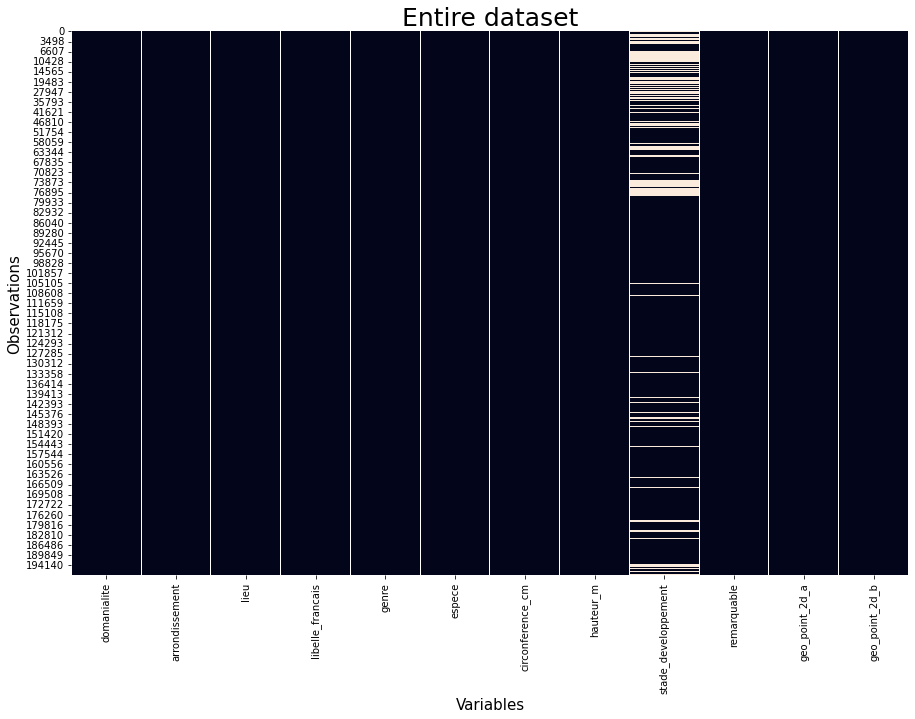

In [26]:
plot_data(df)

## 3.5 Résoudre valeurs lieu: split '/'

In [27]:
#df['split_lieu'] = df.lieu.str.split("/", expand=True)[0].str.strip()
df['split_lieu'] = df.lieu.str.split('/', n=1, expand=True)[0];

# 4. Analyse des données

## 4.1 Variable `libelle_francais`

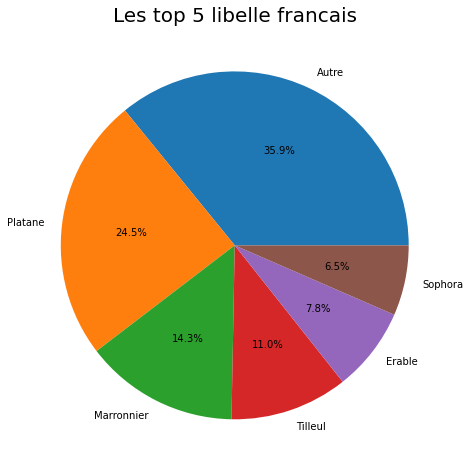

In [28]:
ll = list(df.libelle_francais.value_counts().head(5).index)
df['lf_top5'] = df['libelle_francais']
df.loc[~(df['lf_top5'].isin(ll)),'lf_top5'] = 'Autre'


plt.figure(figsize=(15,8))
df.lf_top5.value_counts().plot.pie(autopct="%.1f%%");
plt.title('Les top 5 libelle francais', fontsize=20);
plt.ylabel('');


#### Synthèse de l’analyse:
 - Les top 5 libelle francais sont Platane (24.5%), Marronier (14.3%), Tilleuil (11%), Erable (7.8%) et Sophora(6.5%). Tout les autre arbre sont de 35.9%.

## 4.2 Variable `arrondissement`

### 4.2.1 Combien des arbres par `arrondissement`?

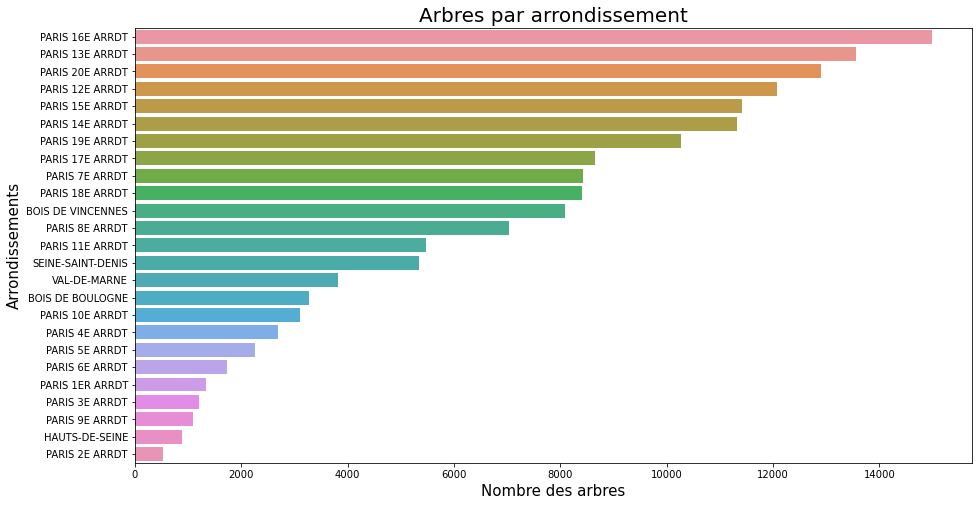

In [29]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.arrondissement.value_counts(), y=df.arrondissement.value_counts().index, data=df);
plt.title('Arbres par arrondissement', fontsize=20);
plt.xlabel('Nombre des arbres', fontsize=15);
plt.ylabel('Arrondissements', fontsize=15);
plt.show();

### 4.2.2 Combien des arbres `remarquables` par `arrondissement`?

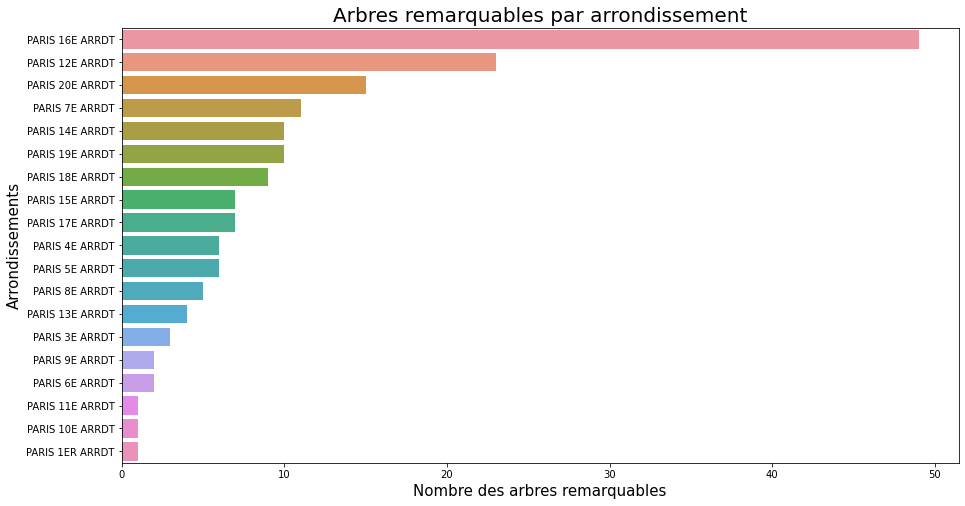

In [30]:
#df[(df.remarquable==1)].arrondissement.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x=df[(df.remarquable==1)].arrondissement.value_counts(), y=df[(df.remarquable==1)].arrondissement.value_counts().index, data=df[(df.remarquable==1)]);
plt.title('Arbres remarquables par arrondissement', fontsize=20);
plt.xlabel('Nombre des arbres remarquables', fontsize=15);
plt.ylabel('Arrondissements', fontsize=15);
plt.show();

#### Synthèse de l’analyse:
 - La zone le plus vert de Paris c'est dans 16EME, 13EME, 20EME, 12EME arrondissements. Il faut avoir plus des personelle pour traiter ces arbre que dans les arrondissements le moins verte comme on voit dans 9EME, 2EME arrondissements et haute de seine.
 - On trouve beaucoup des arbre remarquables dans 16EME, 12EME, 20EME, l'arrondissements. Les personelle qui font la route sur ces arrondissement doivent être formé pour une traitement spécifique des arbres remarquables.
 - On trouve très peux d'arbre remarquables dans 10EME, 1ERE, 11EME arrondissement.

## 4.3 La variable `lieu` et `split_lieu`. 

### 4.3.1 Les difference? Quelle etait l'interet de creation d'un nouvelle variable?

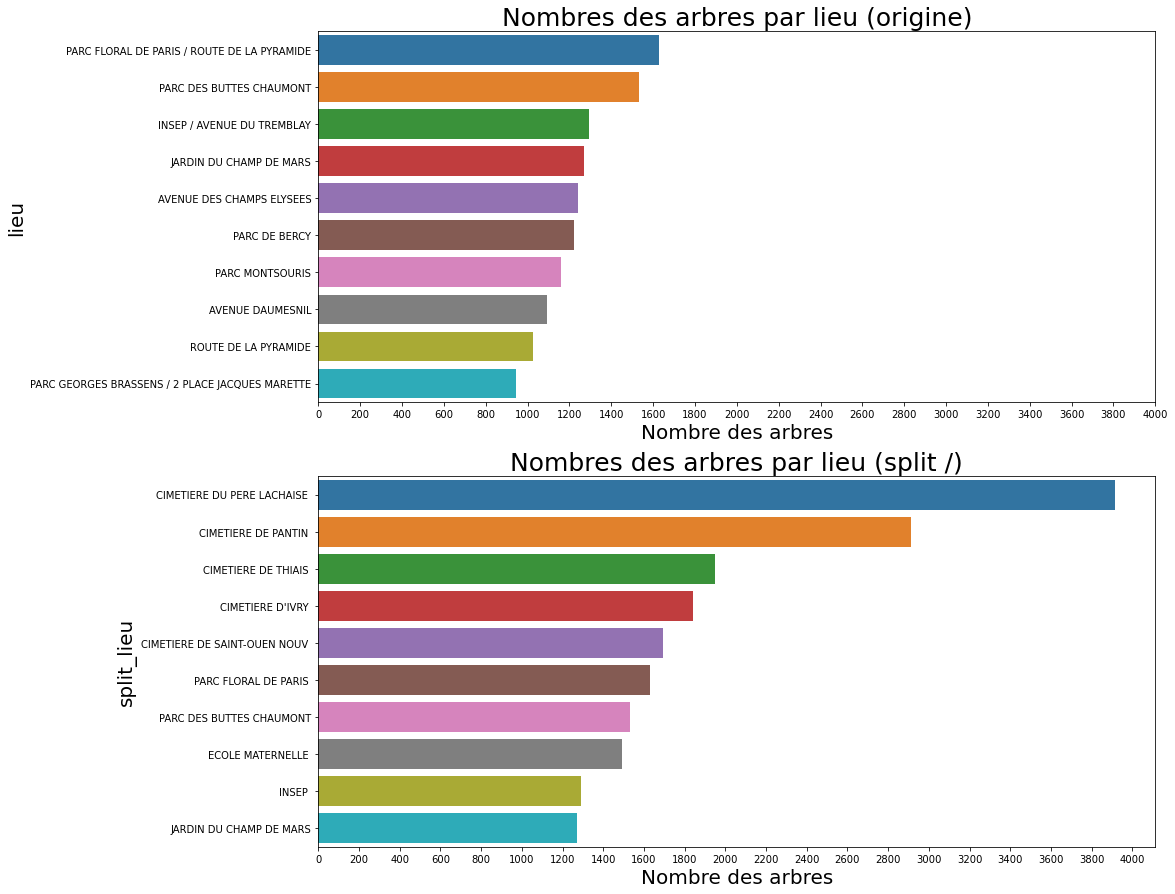

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15));
c1 = sns.countplot(y='lieu', data=df, order=df.lieu.value_counts().iloc[:10].index, ax=axes[0]);
c1.axes.set_xticks(np.arange(0, 4200, 200));

axes[0].set_ylabel('lieu', fontsize=20);
axes[0].set_xlabel('Nombre des arbres', fontsize=20);
axes[0].set_title('Nombres des arbres par lieu (origine)', fontsize=25);

c2 = sns.countplot(y='split_lieu', data=df, order=df.split_lieu.value_counts().iloc[:10].index, ax=axes[1]);
c2.axes.set_xticks(np.arange(0, 4200, 200));
axes[1].set_ylabel('split_lieu', fontsize=20);
axes[1].set_xlabel('Nombre des arbres', fontsize=20);
axes[1].set_title('Nombres des arbres par lieu (split /)', fontsize=25);


#### Synthèse de l’analyse:
 - En splittant le variable lieu on trouve les lieu avec plus d'importance. 
 - On remarque que les cimitieres sont les plus vert à Paris.

### 4.3.2 Quelle genre des arbres on trouve au lieu le plus planté de Paris?

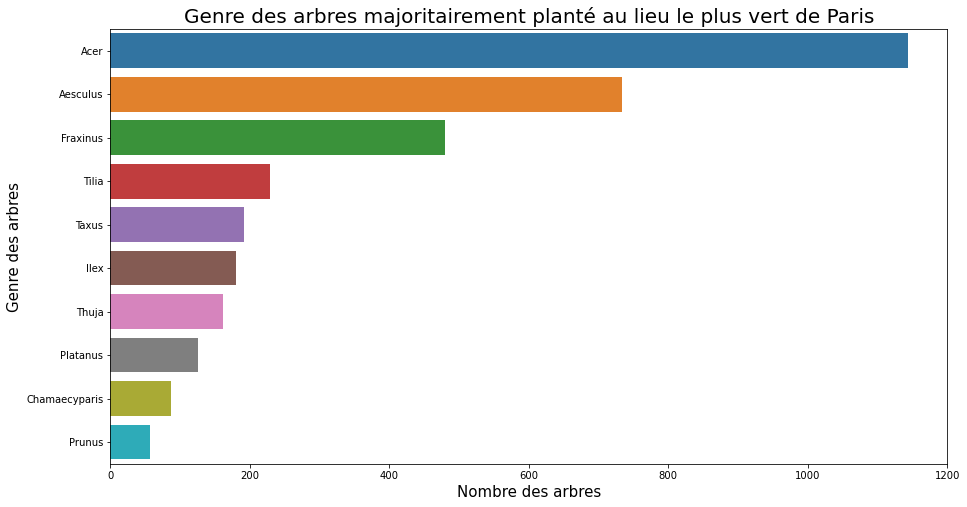

In [32]:
lieu_leplus_plante = df.split_lieu.value_counts().index[0]

plt.figure(figsize=(15,8))
sns.countplot(y='genre', data=df[df.split_lieu == lieu_leplus_plante], order=df[df.split_lieu == lieu_leplus_plante].genre.value_counts().iloc[:10].index);

plt.title('Genre des arbres majoritairement planté au lieu le plus vert de Paris', fontsize=20);
plt.xlabel('Nombre des arbres', fontsize=15);
plt.ylabel('Genre des arbres', fontsize=15);
plt.show();

#### Synthèse de l’analyse:
 - Les genre des arbres les majoritairement planté à Paris c'est Acer (plus de 1000 arbres), Aesculus (plus de 700 arbres) et Fraxinus (plus de 400 arbres). Les autres genre des arbres sont au tour de 200 arbres et moin.

## 4.4 La variable `stade_developpement`. 

### 4.4.1 Les variables de grandeur (`hauteur_m` et `circunference_cm`) par rapport au `stade_developpement` d'un arbre. Aussi classifié par la `remarquable` d'un arbre. 

In [33]:
df[(~df.stade_developpement.isna()) & (df.remarquable==1)].stade_developpement.value_counts()

M     115
A      53
J       1
JA      1
Name: stade_developpement, dtype: int64

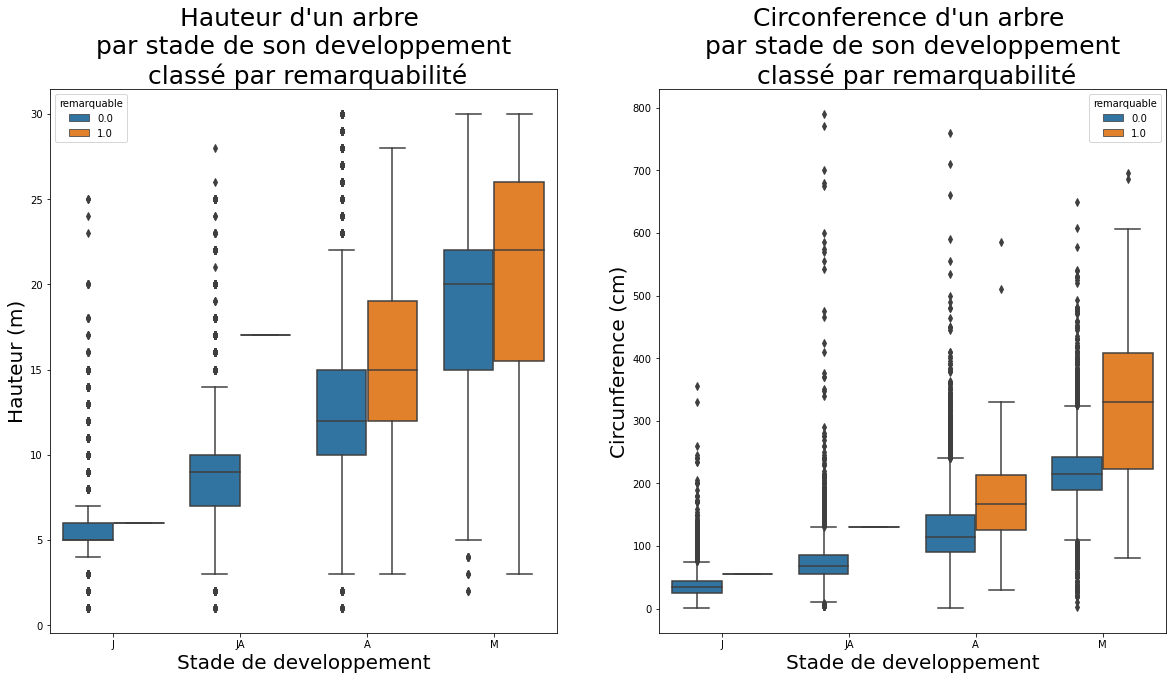

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

#fig.suptitle('Hauteur et Circonference par stade de development', fontsize=50)
sns.boxplot(data=df,
    x="stade_developpement", 
    y="hauteur_m",
    order=['J', 'JA', 'A', 'M'],
    hue="remarquable",
    ax=axes[0],
);
axes[0].set_title('Hauteur d\'un arbre \npar stade de son developpement\n classé par remarquabilité', fontsize=25);
axes[0].set_xlabel('Stade de developpement', fontsize=20);
axes[0].set_ylabel('Hauteur (m)', fontsize=20);
sns.boxplot(data=df,
    x="stade_developpement", 
    y="circonference_cm",
    order=['J', 'JA', 'A', 'M'],
    hue="remarquable",
    ax=axes[1],
);
axes[1].set_title('Circonference d\'un arbre \npar stade de son developpement\n classé par remarquabilité' , fontsize=25);
axes[1].set_xlabel('Stade de developpement', fontsize=20);
axes[1].set_ylabel('Circunference (cm)', fontsize=20);

In [35]:
df[(df.remarquable==1) & ((df.stade_developpement=='J')|(df.stade_developpement=='JA'))]

,domanialite,arrondissement,lieu,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b,split_lieu,lf_top5
13575,Jardin,PARIS 14E ARRDT,SQUARE DE L ASPIRAND DUNAND / 20 RUE SAILLARD,Cèdre,Cedrus,libani,131,17,JA,1.0,48.832000,2.325830,SQUARE DE L ASPIRAND DUNAND,Autre
29851,Jardin,PARIS 3E ARRDT,JARDIN ANNE FRANCK / 14 IMPASSE BERTHAUD,Marronnier,Aesculus,hippocastanum,55,6,J,1.0,48.861474,2.354375,JARDIN ANNE FRANCK,Marronnier


#### Synthèse de l’analyse:

- La `stade_developpement` à une correlation avec l'`hauteur_m` et le `circunference_cm`. Le plus le `hauteur_m` ou Le `circunference_cm` est grande, le `stade_developpement` change de Jeunne à Jeunne Adulte, Adulte et jusqu'a Mature.
- On observe quand même des valeure aberante de `hauteur_m` et `circunference_cm` pour chaque `stade_developpement`. Il faut pêut être re-mesurer ces arbre, ou changé le `stade_developpement`.
- On a 1 arbre remarquable Jeune et 1 Jeune Adulte, par contre on trouve beaucoup des arbre remarquable Adulte et Mature.

## 4.5 La variable `domanialite`. 

### 4.5.1 Sur quelle domaniqlite on a des arbres remarquables? Quest que on peux dire de les taille des arbres (`hauteur_m` et `circonference_cm`) par rapport au `domanialite`? Dans quelle `domanialite` se trouve plus des arbres remarquable?

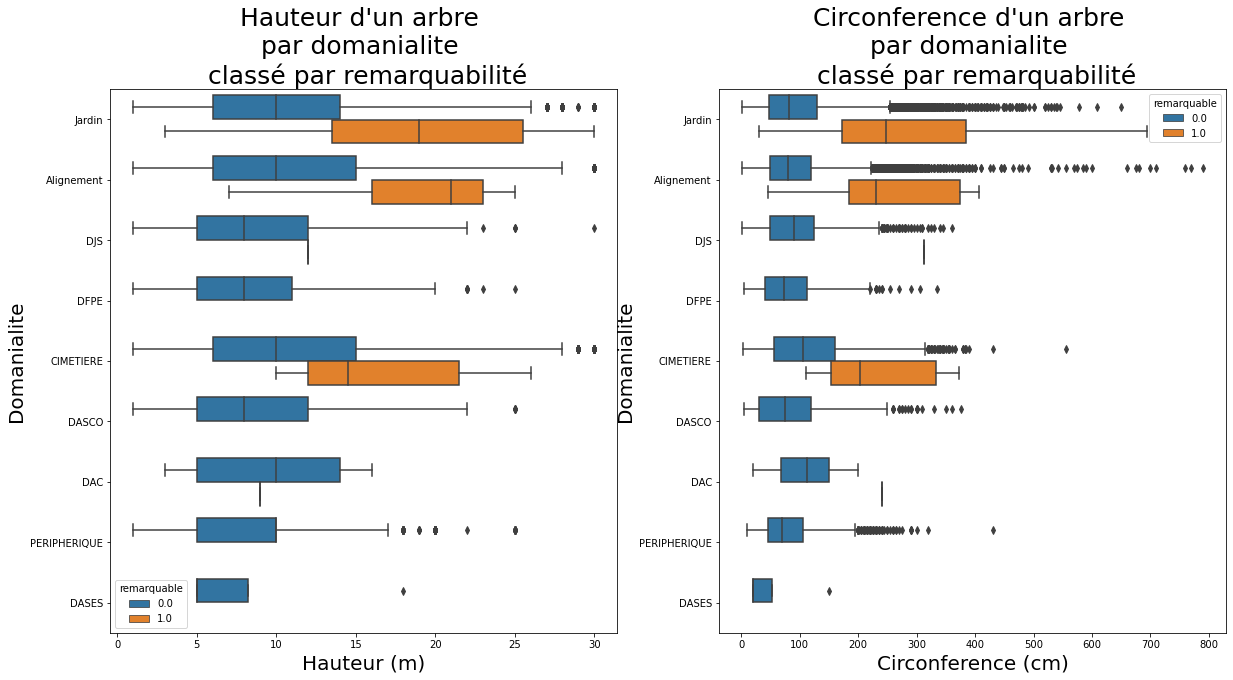

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(data=df,
    y="domanialite", 
    x="hauteur_m",
    order=df.domanialite.unique(),
    hue="remarquable",
    ax=axes[0]
);
axes[0].set_title('Hauteur d\'un arbre \npar domanialite \n classé par remarquabilité', fontsize=25);
axes[0].set_xlabel('Hauteur (m)', fontsize=20);
axes[0].set_ylabel('Domanialite', fontsize=20);

sns.boxplot(data=df,
    y="domanialite", 
    x="circonference_cm",
    order=df.domanialite.unique(),
    hue="remarquable",
    ax=axes[1]
);
axes[1].set_title('Circonference d\'un arbre \npar domanialite \n classé par remarquabilité', fontsize=25);
axes[1].set_xlabel('Circonference (cm)', fontsize=20);
axes[1].set_ylabel('Domanialite', fontsize=20);

#### Synthèse de l’analyse:
 - les arbres remarquables sont plus grands en hauteur et en circonference que ce qui ne sont pas remarquable.
 - les arbres remarquables se trouve dans des Jardin, Alignment, et Cimitiere.
 - on a une arbre remarquable à DJS et une arbre remarquable à DAC. Il faut verifié ces deux arbres.

## 5. Afficher les arbres remarquable dans les Jardin

In [37]:
plot_arbres(df[(df.domanialite == 'Jardin') & (df.remarquable==1)] )